In [50]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data as pt
import torch_optimizer as tr_opt

In [51]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(
    coeffs=[-0.5], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) 
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5], 
    observables=[
        qml.PauliZ(0), qml.PauliZ(1)
    ]
)

## New Hamiltonian

#### Entangler Hamiltonian

$$
H = 
-0.5 \cdot(
 \, Z_0 \otimes Z_1 \otimes I_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes Z_{2} \otimes I_3
 + \, I_{0} \otimes Z_1 \otimes Z_{2} \otimes I_{3} \\
 + \, I_{0} \otimes Z_1 \otimes I_{2} \otimes Z_3
 + \, I_{0} \otimes I_1 \otimes Z_{2} \otimes Z_3 
)
$$


$$
where,
Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}
$$

#### Entangler Hamiltonian_2

$$
H = 
-0.5 \cdot (
 \, Z_0 \otimes Z_1 \otimes I_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes Z_{2} \otimes I_3
 + \, Z_{0} \otimes I_1 \otimes I_{2} \otimes Z_3\\
 + \, I_{0} \otimes Z_1 \otimes Z_{2} \otimes I_{3} 
 + \, I_{0} \otimes Z_1 \otimes I_{2} \otimes Z_3
 + \, I_{0} \otimes I_1 \otimes Z_{2} \otimes Z_3 
)
$$


$$
where,
Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}
$$

#### Phase Accumulator Hamiltonian


$$
H_{1} = -0.5 \cdot (
    Z_0 + Z_1 + Z_2 + Z_3
) 
$$



$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [52]:
# Global Parameters
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   # Dephase tau
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0, 0, 0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [53]:
class INDEX(Enum):
    THETA_X = 0
    
    PHI_Z1 = 1
    PHI_Z2 = 2
    
    TAU_1 = 3
    TAU_2 = 4


In [54]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
        
    phi_z = Paras_global[1]

    tau_1 = Paras_global[2]
    tau_2 = torch.pi/4
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(torch.pi/2, wires=0)
    qml.RY(torch.pi/2, wires=1)
    
    # Stage_2: Entangler  
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)       

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)     

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 

    # Stage_4: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RZ(phi_z, wires=0)
    qml.RZ(phi_z, wires=1)
    
    qml.RX(torch.pi/(2), wires=0)
    qml.RX(torch.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

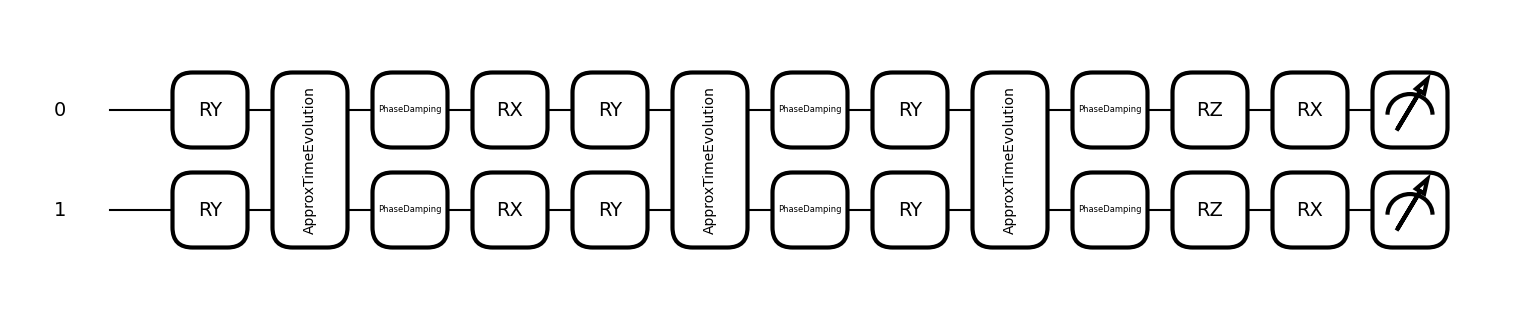

In [55]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [56]:
# @qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
# def Post_selection(phi):

#     global Paras_global, Gamma_ps_global
#     get_density_matrix = circuit(phi)
        
#     # Kraus operator for 2*2 matrix
#     K = torch.tensor([
#         [torch.sqrt(1 - Gamma_ps_global), 0], 
#         [0, 1]
#     ], dtype=torch.complex128)
    
#     I_2 = torch.eye(2)  # 2*2
    
#     num_1 = torch.kron(K, I_2) @ get_density_matrix @ torch.kron(K, I_2).conj().T
#     num_2 = torch.kron(I_2, K) @ get_density_matrix @ torch.kron(I_2, K).conj().T
    
#     den_1 = 2 * torch.trace(num_1)
#     den_2 = 2 * torch.trace(num_2)
    
#     rho_1 = num_1 / den_1
#     rho_2 = num_2 / den_2
    
#     rho_ps = rho_1 + rho_2
    
#     qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
#     return qml.density_matrix(wires = [0, 1])  

In [57]:
@qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=torch.complex128)
    
    Numerator = torch.kron(K, K) @ get_density_matrix @ torch.kron(K, K).conj().T
    Denominator = torch.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac
{(K \otimes I) \rho (K \otimes I)^{\dagger}}
{2Tr[(K \otimes I) \rho (K \otimes I)^{\dagger}]}

+

\frac
{(I \otimes K) \rho (I \otimes K)^{\dagger}}
{2Tr[(I \otimes K) \rho (I \otimes K)^{\dagger}]}
$$

In [58]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])

In [59]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [60]:
def sweep_cfi(sweep_range, initial_parameters):
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        
        Data[phi_idx, 1] = -cost_function(params_tensor)
        
    return Data

In [61]:
def sweep_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection):
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = sweep_cfi(sweep_range, init_par).detach().numpy()
        
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
        
    return Data

In [62]:
import time

def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    opt = tr_opt.select_optimizer(method, params_tensor)
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 15
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    start_time = time.time()
    del_accu = 0
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        elapsed_time = time.time() - start_time
        estimated_total_time = (elapsed_time / (phi_idx + 1)) * len(Phi)
        remaining_time = estimated_total_time - elapsed_time
        
        formatted_x = [f"{x:.8f}" for x in opt.param_groups[0]['params'][0].detach().numpy()]
        
        del_CFI = (Data[phi_idx-1, 1]) + fval if phi_idx > 0 else 0
        del_accu += del_CFI
        print(
            "CFI =", f"{-fval:.5f}", 
            "Paras =", formatted_x, 
            f"[eta : {remaining_time / 60:.2f}_min,",
            f"iter_left : {len(Phi) - phi_idx},", 
            f"del_CFI : {del_CFI:.4f}]",
            f"del_accumulated : {del_accu:.4f}"
        )

        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]        
        
    return Data

In [63]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [64]:
import time
sweep_range = torch.tensor(
    [1e-2, 2*torch.pi, 1e-2], 
    dtype=torch.float, requires_grad=False
)

init_par = torch.tensor([
    # theta_x
    torch.pi/4, 
    
    # phi_z
    torch.pi/4,
    
    # tau_1:2
    torch.pi/4, torch.pi/4
    ], dtype=torch.float)

tau_dephase = 0.005,
gamma_ps = 0

start_time = time.time()
res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')
end_time = time.time()

running_time = (end_time - start_time) / 60

CFI = 3.82452 Paras = ['0.78544062', '0.81876862', '-1.57093108', '0.78539819'] [eta : 28.19_min, iter_left : 628, del_CFI : 0.0000] del_accumulated : 0.0000
CFI = 3.82452 Paras = ['0.78542024', '0.82821643', '-1.57083380', '0.78539819'] [eta : 23.98_min, iter_left : 627, del_CFI : 0.0000] del_accumulated : 0.0000
CFI = 3.82451 Paras = ['0.78540462', '0.83660084', '-1.57081783', '0.78539819'] [eta : 19.71_min, iter_left : 626, del_CFI : 0.0000] del_accumulated : 0.0000
CFI = 3.82452 Paras = ['0.78539997', '0.84729743', '-1.57080352', '0.78539819'] [eta : 17.91_min, iter_left : 625, del_CFI : -0.0000] del_accumulated : 0.0000
CFI = 3.82452 Paras = ['0.78539956', '0.85753906', '-1.57079852', '0.78539819'] [eta : 17.04_min, iter_left : 624, del_CFI : -0.0000] del_accumulated : 0.0000
CFI = 3.82452 Paras = ['0.78539461', '0.86874789', '-1.57079625', '0.78539819'] [eta : 17.10_min, iter_left : 623, del_CFI : -0.0000] del_accumulated : 0.0000
CFI = 3.82453 Paras = ['0.78539205', '0.87876993'

In [65]:
np.save(f"result_[{tau_dephase[0]}]_{running_time:.2f}", res)

In [66]:
len(res[0][0, :])

6

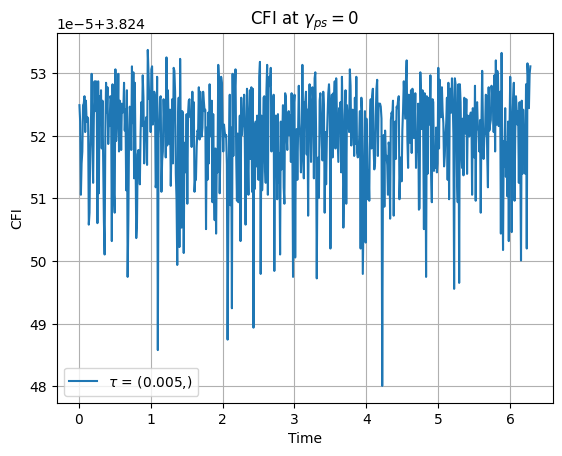

In [67]:
plt.plot(res[0][:,0], res[0][:,1], label = f'$\\tau$ = {tau_dephase}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

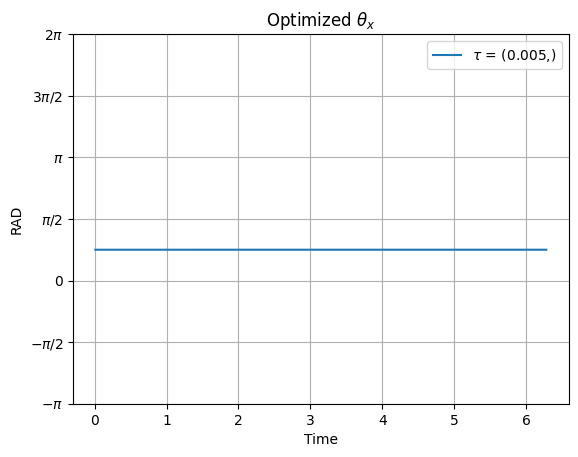

In [68]:
plt.plot(res[0][:,0], res[0][:,INDEX.THETA_X.value + 2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()